# Deep Learning - Assignment 3 - Problem 1
### Ali Abbasi - 98105879

# Importing Libraries

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
torch.manual_seed(24)
np.random.seed(24)

# Datasets and Dataloaders

In [ ]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [ ]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

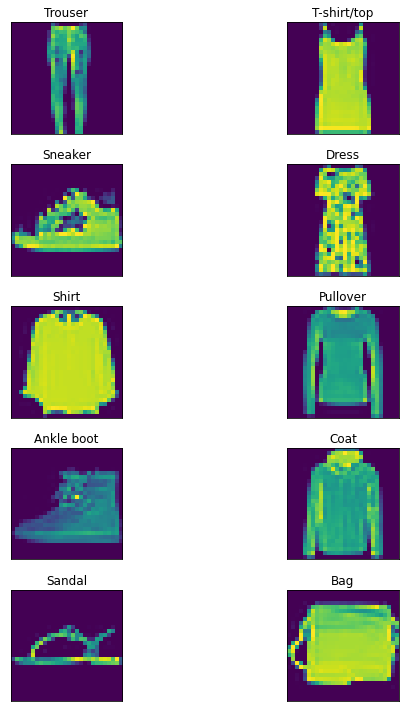

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flat
seen_classes = []
topil = transforms.ToPILImage()
j = 0
while len(seen_classes) != len(train_set.classes):
    i = np.random.randint(0, len(train_set))
    x, y = train_set[i]
    if y in seen_classes:
        continue
    seen_classes.append(y)
    ax = axes[j]
    j += 1
    img = topil(x)
    ax.imshow(img)
    ax.set_title(train_set.classes[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()